In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from keras import models, layers
from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,f1_score
from sklearn.metrics import r2_score, mean_absolute_error
from keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

## Resampling the data on a daily basis

In [10]:
df = pd.read_csv("bitcoin_price.csv")
df.drop(['Open','Close','Volume_(BTC)','Volume_(Currency)','High','Low'],axis=1, inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')
df = df.set_index('Timestamp') #set the index to Timestamp
df_day = df.resample('D').mean()  #Downsample into daily samples

## Finding the NaNs in the dataset

In [11]:
# Find missing values
for i, r in df_day.iterrows():
    if r.isnull().sum() > 0:
        print(i)
        print(r)
        print()

# Print the records of the date between the missing records
print()
print('Data at 2015-01-05')
print(df_day.loc['2015-01-05'])

print()
print('Data at 2015-01-09')
print(df_day.loc['2015-01-09'])

df_day.head(5)

2015-01-06 00:00:00
Weighted_Price   NaN
Name: 2015-01-06 00:00:00, dtype: float64

2015-01-07 00:00:00
Weighted_Price   NaN
Name: 2015-01-07 00:00:00, dtype: float64

2015-01-08 00:00:00
Weighted_Price   NaN
Name: 2015-01-08 00:00:00, dtype: float64


Data at 2015-01-05
Weighted_Price    272.13919
Name: 2015-01-05 00:00:00, dtype: float64

Data at 2015-01-09
Weighted_Price    291.885251
Name: 2015-01-09 00:00:00, dtype: float64


,Weighted_Price
Timestamp,
2011-12-31,4.471603
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159


## Replace the NaNs with the mean value of the day before and after

In [12]:
missing_replacement = df['2015-01-05': '2015-01-09'].mean(numeric_only=True)
df_day.loc['2015-01-06'] = missing_replacement
df_day.loc['2015-01-07'] = missing_replacement
df_day.loc['2015-01-08'] = missing_replacement

# Any missing value?
df_day.isnull().sum(),df_day.head()

(Weighted_Price    0
 dtype: int64,
             Weighted_Price
 Timestamp                 
 2011-12-31        4.471603
 2012-01-01        4.806667
 2012-01-02        5.000000
 2012-01-03        5.252500
 2012-01-04        5.208159)

## Scale the dataset from 0 to 1

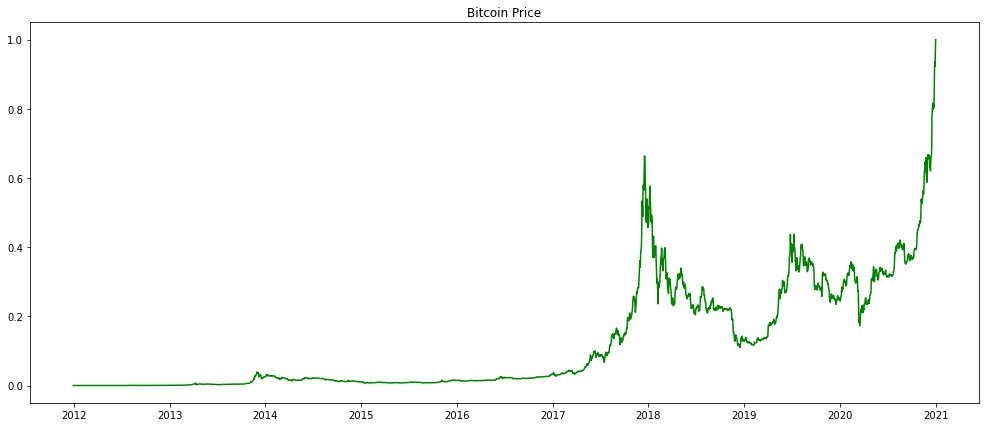

(3289, 1)

In [13]:
scaler = MinMaxScaler()
price = scaler.fit_transform(np.array(df_day['Weighted_Price']).reshape(-1,1))
df_day['Weighted_Price'] = price
plt.figure(figsize=(17,7))
plt.plot(df_day, 'green' )
plt.title('Bitcoin Price')
plt.savefig('./bitcoin price.jpg')
plt.show()
df_day.shape

## Define the window size and split the training test data

In [14]:
window_size = (date(2020, 8, 18) - date(2020, 5, 10)).days
df_train = df_day.loc['2011-12-31':'2019-12-31'] # training the model with data set before 2019-12-31
df_test = df_day.loc['2020-01-01':]
X_l = []
y_l = []
N = len(df_train)
D = window_size
for i in range(N-D-1):
    X_l.append(df_train.iloc[i:i+D])
    y_l.append(df_train.iloc[i+D])
    
X = np.array(X_l)
y = np.array(y_l)

print(X.shape, y.shape)
X,y

(2822, 100, 1) (2822, 1)


(array([[[4.84127347e-06],
         [1.64332372e-05],
         [2.31218531e-05],
         ...,
         [2.04597313e-05],
         [1.72471536e-05],
         [1.51315740e-05]],
 
        [[1.64332372e-05],
         [2.31218531e-05],
         [3.18574160e-05],
         ...,
         [1.72471536e-05],
         [1.51315740e-05],
         [1.61711441e-05]],
 
        [[2.31218531e-05],
         [3.18574160e-05],
         [3.03233928e-05],
         ...,
         [1.51315740e-05],
         [1.61711441e-05],
         [1.69659849e-05]],
 
        ...,
 
        [[3.45454012e-01],
         [3.51842704e-01],
         [3.47138508e-01],
         ...,
         [2.49321833e-01],
         [2.49676064e-01],
         [2.48661843e-01]],
 
        [[3.51842704e-01],
         [3.47138508e-01],
         [3.45082298e-01],
         ...,
         [2.49676064e-01],
         [2.48661843e-01],
         [2.52358532e-01]],
 
        [[3.47138508e-01],
         [3.45082298e-01],
         [3.41575158e-01],
         

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state= 100)

## Define the LSTM model

In [9]:
m_x = layers.Input(shape = X_train.shape[1:])
m_h = layers.LSTM(10)(m_x)
m_y = layers.Dense(1)(m_h)
m = models.Model(m_x,m_y)
m.compile('adam','mse')
m.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 1)]          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


## Training period (500 epochs)

In [10]:
history = m.fit(X_train, y_train, epochs=500, validation_data=(X_test, y_test),verbose=1)

Epoch 1/500
71/71 [==============================] - 2s 32ms/step - loss: 0.0033 - val_loss: 4.0761e-04
Epoch 2/500
71/71 [==============================] - 2s 23ms/step - loss: 4.0174e-04 - val_loss: 3.1973e-04
Epoch 3/500
71/71 [==============================] - 2s 22ms/step - loss: 3.3407e-04 - val_loss: 2.7506e-04
Epoch 4/500
71/71 [==============================] - 2s 22ms/step - loss: 2.9560e-04 - val_loss: 2.4655e-04
Epoch 5/500
71/71 [==============================] - 2s 23ms/step - loss: 2.8605e-04 - val_loss: 2.3959e-04
Epoch 6/500
71/71 [==============================] - 2s 22ms/step - loss: 2.6405e-04 - val_loss: 2.1597e-04
Epoch 7/500
71/71 [==============================] - 2s 22ms/step - loss: 2.4266e-04 - val_loss: 2.4275e-04
Epoch 8/500
71/71 [==============================] - 2s 22ms/step - loss: 2.3897e-04 - val_loss: 1.9574e-04
Epoch 9/500
71/71 [==============================] - 2s 21ms/step - loss: 2.2943e-04 - val_loss: 2.3795e-04
Epoch 10/500
71/71 [============

In [25]:
m.save('my_LSTMmodel2.h5')

## Plot the loss evaluation during training

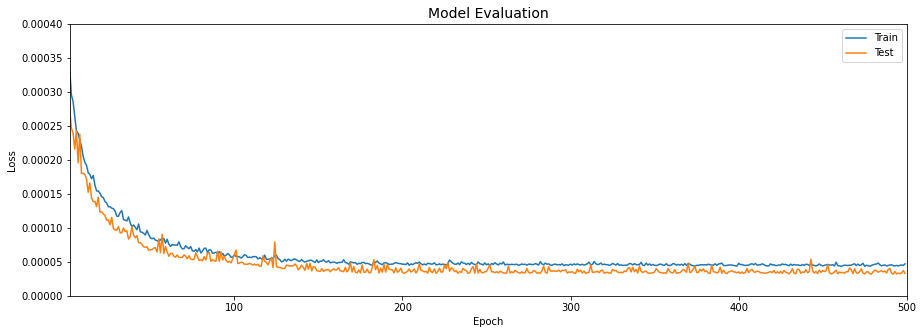

In [26]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train','Test'])
plt.title("Model Evaluation", fontsize=14)
plt.xlabel('Epoch')
plt.xlim(2,500)
plt.ylim(0,0.0004)
plt.ylabel('Loss')
plt.savefig('LSTMloss.png')
plt.show()

## Predict the Bitcoin price 

In [16]:
m= models.load_model('my_LSTMmodel2.h5')

pred = []

pr = m.predict(np.array(df_day[2822:2922])) # use the 100 data before 2019-12-31 to predict the next (future) 100 prices.

pred.append(pr[0])

for i in range(1,100):
    pr = m.predict(np.concatenate((np.array(df_day[2822+i:2922]), pred[:]), axis=0)) # one-step ahead prediction
    pred.append(pr[0])


pred

[array([0.3422142], dtype=float32),
 array([0.33852026], dtype=float32),
 array([0.3219728], dtype=float32),
 array([0.28655446], dtype=float32),
 array([0.2793968], dtype=float32),
 array([0.2717088], dtype=float32),
 array([0.27603734], dtype=float32),
 array([0.2729657], dtype=float32),
 array([0.27291727], dtype=float32),
 array([0.2834137], dtype=float32),
 array([0.2796146], dtype=float32),
 array([0.27915907], dtype=float32),
 array([0.27560046], dtype=float32),
 array([0.2741987], dtype=float32),
 array([0.26957536], dtype=float32),
 array([0.27176487], dtype=float32),
 array([0.27787668], dtype=float32),
 array([0.28255916], dtype=float32),
 array([0.29061335], dtype=float32),
 array([0.28473976], dtype=float32),
 array([0.28238708], dtype=float32),
 array([0.28327623], dtype=float32),
 array([0.281455], dtype=float32),
 array([0.27985585], dtype=float32),
 array([0.27262437], dtype=float32),
 array([0.2714776], dtype=float32),
 array([0.2689453], dtype=float32),
 array([0.268

## Plot the prediction results

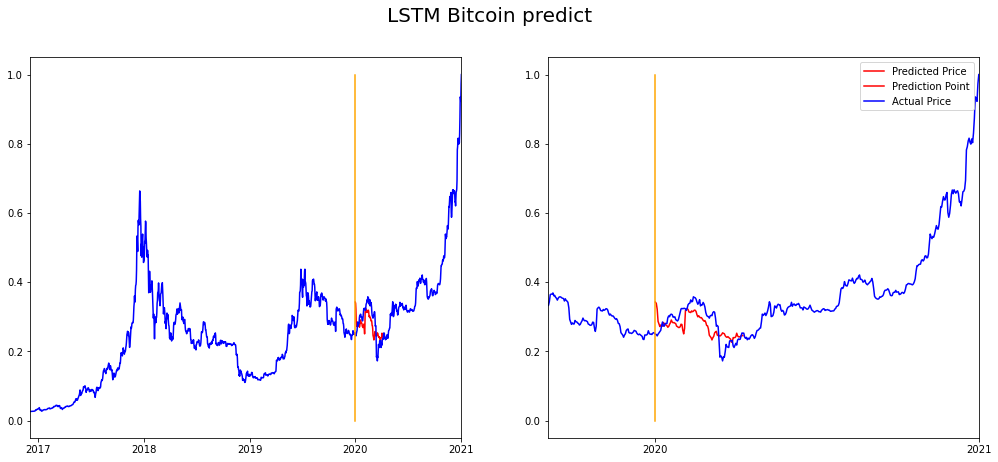

       price
0   0.342214
1   0.338520
2   0.321973
3   0.286554
4   0.279397
..       ...
95  0.242195
96  0.241141
97  0.244984
98  0.246672
99  0.244955

[100 rows x 1 columns]


((3289, 1), (100, 2))

In [17]:
pred = pd.DataFrame(pred)

pred = pred.reset_index()

pred.columns = ['z','price']

pred.drop(['z'],axis=1,inplace=True)


plot_data= df_day.reset_index().drop('Timestamp',axis=1)
plot_data1=plot_data[:2922]
data = pd.concat([plot_data1,pred],ignore_index=True) # concat the data before prediction time point with prediction result

plt.figure(figsize=(17,7))

plt.subplot(1, 2, 1)

plt.plot(data[-100:],'red') # plot the prediction part
plt.plot(plot_data,'blue')
plt.plot([2922, 2922], [0, 1], 'orange')
plt.xticks([0, 366, 731,1096,1461,1827,2192,2557,2922,3288], ['2012', '2013', '2014','2015','2016','2017','2018','2019','2020','2021'])  # Set text labels and properties.

plt.xlim(1800,3288)


plt.subplot(1, 2, 2)

plt.plot(data[-100:],'red')
plt.plot(plot_data,'blue')
plt.plot([2922, 2922], [0, 1], 'orange')
plt.xticks([0, 366, 731,1096,1461,1827,2192,2557,2922,3288], ['2012', '2013', '2014','2015','2016','2017','2018','2019','2020','2021'])  # Set text labels and properties.
plt.legend(['Predicted Price','Prediction Point','Actual Price'])
plt.xlim(2800,3288)

plt.suptitle("LSTM Bitcoin predict",fontsize=20)

plt.savefig('LSTMPpred')
plt.show()

print(pred)
plot_data.shape,data[-100:].shape

## Performance Evaluation

In [11]:
y_test = df_test.Weighted_Price.values[0:window_size]
mean_squared_error(y_test, pred, squared=False), mean_absolute_percentage_error(y_test, pred)

(0.03850773740468789, 0.115995633615149)

In [16]:
r2_score(y_test, pred), mean_absolute_error(y_test, pred)

(0.37731739073991044, 0.03126302625326613)